# Image Captioning with Transformers
### Encoder-Decoder Architecture

<img src="./llm_architecture_comparison.png" width="600" align="center">
<br>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import math
from tqdm.notebook import trange, tqdm
import random

import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torch.distributions import Categorical

import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision

# huggingface transformers library
from transformers import AutoTokenizer
os.environ["TOKENIZERS_PARALLELISM"] = "false"

torch.backends.cuda.matmul.allow_tf32 = True

In [2]:
# learning rate for optimizer
learning_rate = 1e-4

# image size
image_size = 128

# number of epochs for training
nepochs = 120

# batch size for training loop
batch_size = 128

# used COCO dataset 2014 on kaggle
# available at https://www.kaggle.com/datasets/jeffaudi/coco-2014-dataset-for-yolov3 (for images)
# also used captions dataset for COCO 2014
# available at https://www.kaggle.com/datasets/sepehrnoey/ms-coco-2014-captions (for captions)

# setting directories of datasets
data_set_root='/kaggle/input/coco-2014-dataset-for-yolov3/coco2014/images'
train_set ='train2014'
validation_set ='val2014'

train_image_path = os.path.join(data_set_root, train_set)
train_ann_file = '/kaggle/input/ms-coco-2014-captions/captions_train2014.json'

val_image_path = os.path.join(data_set_root, validation_set)
val_ann_file = '/kaggle/input/ms-coco-2014-captions/captions_val2014.json'

## Data processing and Tokenization

In [3]:
# a simple transform class to randomly sample one of the five captions
class SampleCaption(nn.Module):
    def __call__(self, sample):
        rand_index = random.randint(0, len(sample) - 1)
        return sample[rand_index]

In [4]:
!pip install pycocotools

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 427.8/427.8 kB 5.5 MB/s eta 0:00:0000:010:01


In [5]:
# defining transformations on datasets and defining the dataloaders
train_transform = transforms.Compose([transforms.Resize(image_size),
                                      transforms.RandomCrop(image_size),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                           std=[0.229, 0.224, 0.225]),
                                      transforms.RandomErasing(p=0.5)]) 

transform = transforms.Compose([transforms.Resize(image_size),
                                transforms.CenterCrop(image_size),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                     std=[0.229, 0.224, 0.225])]) 

train_dataset = datasets.CocoCaptions(root=train_image_path,
                                      annFile=train_ann_file,
                                      transform=train_transform,
                                      target_transform=SampleCaption())

val_dataset = datasets.CocoCaptions(root=val_image_path,
                                    annFile=val_ann_file,
                                    transform=transform,
                                    target_transform=SampleCaption())

data_loader_train = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=8)
data_loader_val = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=8)

loading annotations into memory...
Done (t=1.63s)
creating index...
index created!
loading annotations into memory...
Done (t=0.77s)
creating index...
index created!


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [6]:
# dataloader itterable object
dataiter = next(iter(data_loader_val))
# sampling from the itterable object
test_images, test_captions = dataiter

A street sign reading Cambridge st and Norfolk st's crossing lies broken on the ground. 


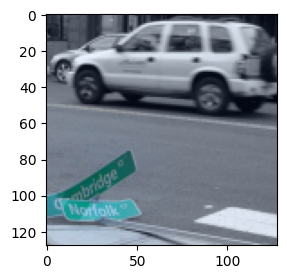

In [7]:
# visualize an image to get familiar with dataset
plt.figure(figsize = (3,3))
out = torchvision.utils.make_grid(test_images[0:1], 1, normalize=True)
_ = plt.imshow(out.numpy().transpose((1, 2, 0)))

caption = test_captions[0]
print(caption)

In [8]:
# used a pre-built Tokenizer for the BERT Model
# https://towardsdatascience.com/bert-explained-state-of-the-art-language-model-for-nlp-f8b21a9b6270
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [9]:
tokenizer.vocab_size

30522

In [10]:
tokens = tokenizer(test_captions, padding=True, truncation=True, return_tensors="pt")

In [11]:
tokens['attention_mask']

tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])

In [12]:
token_ids = tokens['input_ids'][0]
tokens['input_ids']

tensor([[  101,  1037,  2395,  ...,     0,     0,     0],
        [  101,  1037,  2200,  ...,     0,     0,     0],
        [  101,  2304,  1011,  ...,     0,     0,     0],
        ...,
        [  101,  1037,  2270,  ...,     0,     0,     0],
        [  101,  1037,  2317,  ...,     0,     0,     0],
        [  101,  2019, 10777,  ...,     0,     0,     0]])

In [13]:
print(tokenizer.decode(token_ids))

[CLS] a street sign reading cambridge st and norfolk st's crossing lies broken on the ground. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]


In [14]:
class TokenDrop(nn.Module):
    """For a batch of tokens indices, randomly replace a non-specical token.
    
    Args:
        prob (float): probability of dropping a token
        blank_token (int): index for the blank token
        num_special (int): Number of special tokens, assumed to be at the start of the vocab
    """

    def __init__(self, prob=0.1, blank_token=1, eos_token=102):
        self.prob = prob
        self.eos_token = eos_token
        self.blank_token = blank_token

    def __call__(self, sample):
        # Randomly sample a bernoulli distribution with p=prob
        # to create a mask where 1 means we will replace that token
        mask = torch.bernoulli(self.prob * torch.ones_like(sample)).long()
        
        # only replace if the token is not the eos token
        can_drop = (~(sample == self.eos_token)).long()
        mask = mask * can_drop
        
        # Do not replace the sos tokens
        mask[:, 0] = torch.zeros_like(mask[:, 0]).long()
        
        replace_with = (self.blank_token * torch.ones_like(sample)).long()
        
        sample_out = (1 - mask) * sample + mask * replace_with
        
        return sample_out

## Create Encoder-Decoder Network

In [15]:
def extract_patches(image_tensor, patch_size=16):
    # getting the dimensions of the image tensor
    bs, c, h, w = image_tensor.size()
    
    # defining the Unfold layer with appropriate parameters
    unfold = torch.nn.Unfold(kernel_size=patch_size, stride=patch_size)
    
    # applying Unfold to the image tensor
    unfolded = unfold(image_tensor)
    
    # reshaping the unfolded tensor to match the desired output shape
    # output shape: BSxLxH, where L is the number of patches in each dimension
    unfolded = unfolded.transpose(1, 2).reshape(bs, -1, c * patch_size * patch_size)
    
    return unfolded

# sinusoidal positional embeds
class SinusoidalPosEmb(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, x):
        device = x.device
        half_dim = self.dim // 2
        emb = math.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=device) * -emb)
        emb = x[:, None] * emb[None, :]
        emb = torch.cat((emb.sin(), emb.cos()), dim=-1)
        return emb
    

# define a module for attention blocks
class AttentionBlock(nn.Module):
    def __init__(self, hidden_size=128, num_heads=4, masking=True):
        super(AttentionBlock, self).__init__()
        self.masking = masking

        # multi-head attention mechanism
        self.multihead_attn = nn.MultiheadAttention(hidden_size,
                                                    num_heads=num_heads,
                                                    batch_first=True,
                                                    dropout=0.0)

    def forward(self, x_in, kv_in, key_mask=None):
        # apply causal masking if enabled
        if self.masking:
            bs, l, h = x_in.shape
            mask = torch.triu(torch.ones(l, l, device=x_in.device), 1).bool()
        else:
            mask = None
            
        # performing multi-head attention operation
        return self.multihead_attn(x_in, kv_in, kv_in, attn_mask=mask, 
                                   key_padding_mask=key_mask)[0]


# defining a module for a transformer block with self-attention 
# and optional causal masking
class TransformerBlock(nn.Module):
    def __init__(self, hidden_size=128, num_heads=4, decoder=False, masking=True):
        super(TransformerBlock, self).__init__()
        self.decoder = decoder

        # layer normalization for the input
        self.norm1 = nn.LayerNorm(hidden_size)
        # self-attention mechanism
        self.attn1 = AttentionBlock(hidden_size=hidden_size, num_heads=num_heads, 
                                    masking=masking)
        
        # layer normalization for the output of the first attention layer
        if self.decoder:
            self.norm2 = nn.LayerNorm(hidden_size)
            # self-attention mechanism for the decoder with no masking
            self.attn2 = AttentionBlock(hidden_size=hidden_size, 
                                        num_heads=num_heads, masking=False)
        
        # layer normalization for the output before the MLP
        self.norm_mlp = nn.LayerNorm(hidden_size)
        # multi-layer perceptron (MLP)
        self.mlp = nn.Sequential(nn.Linear(hidden_size, hidden_size * 4),
                                 nn.ELU(),
                                 nn.Linear(hidden_size * 4, hidden_size))
                
    def forward(self, x, input_key_mask=None, cross_key_mask=None, kv_cross=None):
        # performing self-attention operation
        x = self.attn1(x, x, key_mask=input_key_mask) + x
        x = self.norm1(x)

        # if decoder, perform additional cross-attention layer
        if self.decoder:
            x = self.attn2(x, kv_cross, key_mask=cross_key_mask) + x
            x = self.norm2(x)

        # applying MLP and layer normalization
        x = self.mlp(x) + x
        return self.norm_mlp(x)

    
# defining a decoder module for the Transformer architecture
class Decoder(nn.Module):
    def __init__(self, num_emb, hidden_size=128, num_layers=3, num_heads=4):
        super(Decoder, self).__init__()
        
        # creating an embedding layer for tokens
        self.embedding = nn.Embedding(num_emb, hidden_size)
        # initializing the embedding weights
        self.embedding.weight.data = 0.001 * self.embedding.weight.data

        # initializing sinusoidal positional embeddings
        self.pos_emb = SinusoidalPosEmb(hidden_size)
        
        # creating multiple transformer blocks as layers
        self.blocks = nn.ModuleList([
            TransformerBlock(hidden_size, num_heads, 
                             decoder=True) for _ in range(num_layers)
        ])
                
        # defining a linear layer for output prediction
        self.fc_out = nn.Linear(hidden_size, num_emb)
        
    def forward(self, input_seq, encoder_output, input_padding_mask=None, 
                encoder_padding_mask=None):        
        # embedding the input sequence
        input_embs = self.embedding(input_seq)
        bs, l, h = input_embs.shape

        # adding positional embeddings to the input embeddings
        seq_indx = torch.arange(l, device=input_seq.device)
        pos_emb = self.pos_emb(seq_indx).reshape(1, l, h).expand(bs, l, h)
        embs = input_embs + pos_emb
        
        # passing the embeddings through each transformer block
        for block in self.blocks:
            embs = block(embs, 
                           input_key_mask=input_padding_mask, 
                           cross_key_mask=encoder_padding_mask, 
                           kv_cross=encoder_output)
        
        return self.fc_out(embs)

    
# defining an Vision Encoder module for the Transformer architecture
class VisionEncoder(nn.Module):
    def __init__(self, image_size, channels_in, patch_size=16, hidden_size=128, 
                 num_layers=3, num_heads=4):
        super(VisionEncoder, self).__init__()
        
        self.patch_size = patch_size
        self.fc_in = nn.Linear(channels_in * patch_size * patch_size, hidden_size)
        
        seq_length = (image_size // patch_size) ** 2
        self.pos_embedding = nn.Parameter(torch.empty(1, seq_length, 
                                                      hidden_size).normal_(std=0.02))
        
        # creating multiple transformer blocks as layers
        self.blocks = nn.ModuleList([
            TransformerBlock(hidden_size, num_heads, 
                             decoder=False, masking=False) for _ in range(num_layers)
        ])
                
    def forward(self, image):  
        bs = image.shape[0]

        patch_seq = extract_patches(image, patch_size=self.patch_size)
        patch_emb = self.fc_in(patch_seq)

        # adding a unique embedding to each token embedding
        embs = patch_emb + self.pos_embedding
        
        # passing the embeddings through each transformer block
        for block in self.blocks:
            embs = block(embs)
        
        return embs
    
    
# defining an Vision Encoder-Decoder module for the Transformer architecture
class VisionEncoderDecoder(nn.Module):
    def __init__(self, image_size, channels_in, num_emb, patch_size=16, 
                 hidden_size=128, num_layers=(3, 3), num_heads=4):
        super(VisionEncoderDecoder, self).__init__()
        
        # creating an encoder and decoder with specified parameters
        self.encoder = VisionEncoder(image_size=image_size, channels_in=channels_in, 
                                     patch_size=patch_size, hidden_size=hidden_size, 
                                     num_layers=num_layers[0], num_heads=num_heads)
        
        self.decoder = Decoder(num_emb=num_emb, hidden_size=hidden_size, 
                               num_layers=num_layers[1], num_heads=num_heads)

    def forward(self, input_image, target_seq, padding_mask):
        # generating padding masks for the target sequence
        bool_padding_mask = padding_mask == 0

        # encoding the input sequence
        encoded_seq = self.encoder(image=input_image)
        
        # decoding the target sequence using the encoded sequence
        decoded_seq = self.decoder(input_seq=target_seq, 
                                   encoder_output=encoded_seq, 
                                   input_padding_mask=bool_padding_mask)
        return decoded_seq

## Initialize Model and Optimizer

In [16]:
# # check if GPU is available, set device accordingly
# device = torch.device(0 if torch.cuda.is_available() else 'cpu')
# print(device)
# # embedding Size
# hidden_size = 192

# # number of Transformer blocks for the (Encoder, Decoder)
# num_layers = (6, 6)

# # MultiheadAttention Heads
# num_heads = 8

# # size of the patches
# patch_size = 8

# # create model
# caption_model = VisionEncoderDecoder(image_size=image_size, channels_in=test_images.shape[1], 
#                                      num_emb=tokenizer.vocab_size, patch_size=patch_size, 
#                                      num_layers=num_layers,hidden_size=hidden_size, 
#                                      num_heads=num_heads).to(device)

# # initialize the optimizer with above parameters
# optimizer = optim.Adam(caption_model.parameters(), lr=learning_rate)

# scaler = torch.cuda.amp.GradScaler()

# # define the loss function
# loss_fn = nn.CrossEntropyLoss(reduction="none")

# td = TokenDrop(0.5)

# # initialize the training loss logger
# training_loss_logger = []

cuda:0


/tmp/ipykernel_188/3160447434.py:25: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


In [17]:
# # let's see how many Parameters our Model has!
# num_model_params = 0
# for param in caption_model.parameters():
#     num_model_params += param.flatten().shape[0]

# print("-This Model Has %d (Approximately %d Million) Parameters!" % (num_model_params, num_model_params//1e6))

-This Model Has 18067194 (Approximately 18 Million) Parameters!


## Training

In [ ]:
# # iterate over epochs
# for epoch in trange(0, nepochs, leave=False, desc="Epoch"):
#     # set the model in training mode
#     caption_model.train()
#     steps = 0
#     # iterate over the training data loader
#     for images, captions in tqdm(data_loader_train, desc="Training", leave=False):
        
#         images = images.to(device)
        
#         # tokenize and pre-process the captions
#         tokens = tokenizer(captions, padding=True, truncation=True, return_tensors="pt")
#         token_ids = tokens['input_ids'].to(device)
#         padding_mask = tokens['attention_mask'].to(device)
#         bs = token_ids.shape[0]
        
#         # shift the input sequence to create the target sequence
#         target_ids = torch.cat((token_ids[:, 1:], 
#                                 torch.zeros(bs, 1, device=device).long()), 1)
        
#         tokens_in = td(token_ids)
#         with torch.cuda.amp.autocast():
#             # forward pass
#             pred = caption_model(images, tokens_in, padding_mask=padding_mask)

#         # compute the loss
#         loss = (loss_fn(pred.transpose(1, 2), target_ids) * padding_mask).mean()

#         # backpropagation
#         optimizer.zero_grad()
#         scaler.scale(loss).backward()
#         scaler.step(optimizer)
#         scaler.update()
        
#         # log the training loss
#         training_loss_logger.append(loss.item())

### Saving a checkpoint after 100 epochs

In [ ]:
# torch.save({
#             'epoch': 120,
#             'model_state_dict': caption_model.state_dict(),
#             'optimizer_state_dict': optimizer.state_dict(),
#             'loss': loss.item(),
#             'scaler': scaler.state_dict(),
#             'training_loss_logger': training_loss_logger,
#             }, '/kaggle/working/checkpoint120.pth')

### Load the model and test it

In [18]:
# check if GPU is available, set device accordingly
device = torch.device(0 if torch.cuda.is_available() else 'cpu')
print(device)
# embedding Size
hidden_size = 192

# number of Transformer blocks for the (Encoder, Decoder)
num_layers = (6, 6)

# MultiheadAttention Heads
num_heads = 8

# Size of the patches
patch_size = 8

# Create model
loaded_model = VisionEncoderDecoder(image_size=image_size, channels_in=test_images.shape[1], 
                                     num_emb=tokenizer.vocab_size, patch_size=patch_size, 
                                     num_layers=num_layers,hidden_size=hidden_size, 
                                     num_heads=num_heads).to(device)

cuda:0


In [19]:
checkpoint = torch.load('/kaggle/input/image-captioning-checkpoint100/checkpoint120.pth', weights_only=True)
loaded_model.load_state_dict(checkpoint['model_state_dict'])
training_loss_logger = checkpoint['training_loss_logger']

## Plot Loss

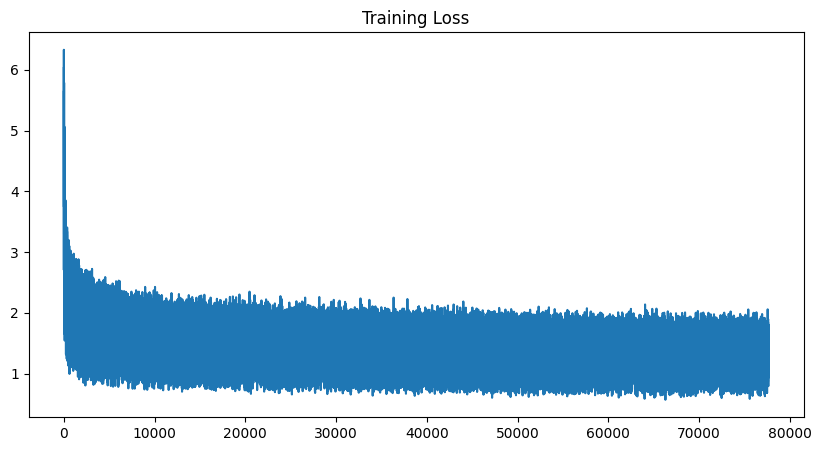

In [20]:
_ = plt.figure(figsize=(10, 5))
_ = plt.plot(training_loss_logger[:])
_ = plt.title("Training Loss")

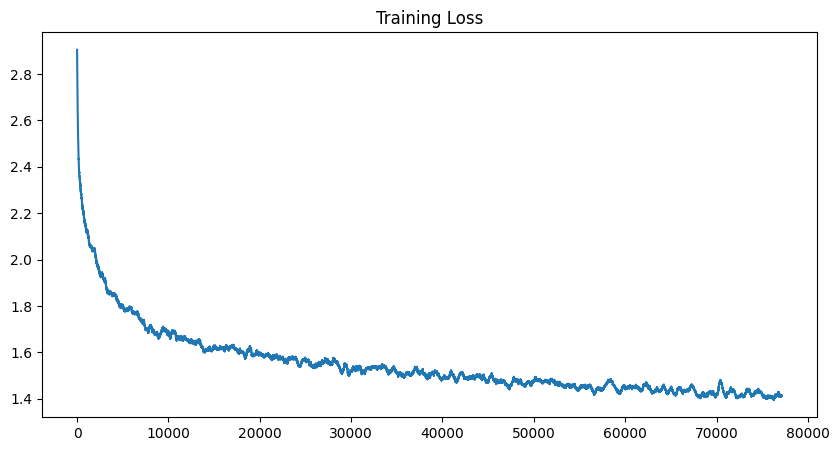

In [21]:
window_size = 512
data = np.convolve(np.array(training_loss_logger), np.ones(window_size)/window_size, mode="valid")
_ = plt.figure(figsize=(10, 5))
_ = plt.plot(data)
_ = plt.title("Training Loss")

## Testing

In [52]:
# create a dataloader itterable object
dataiter = next(iter(data_loader_val))
# sample from the itterable object
test_images, test_captions = dataiter

In [53]:
# choose an index within the batch
index = 0
test_image = test_images[index].unsqueeze(0)

some people with cameras some standing and others are sitting


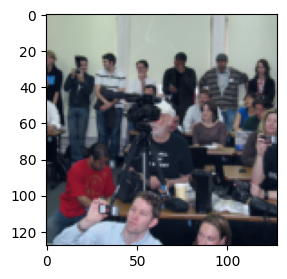

In [54]:
# visualize some of our images
plt.figure(figsize = (3,3))
out = torchvision.utils.make_grid(test_image, 1, normalize=True)
_ = plt.imshow(out.numpy().transpose((1, 2, 0)))
print(test_captions[index])

In [55]:
# add the Start-Of-Sentence token to the prompt to signal the network to start generating the caption
sos_token = 101 * torch.ones(1, 1).long()

# set the temperature for sampling during generation
temp = 0.5

In [58]:
log_tokens = [sos_token]
loaded_model.eval()

with torch.no_grad():
    # encode the input image
    with torch.cuda.amp.autocast():
        # forward pass
        image_embedding = loaded_model.encoder(test_image.to(device))

    # generate the answer tokens
    for i in range(50):
        input_tokens = torch.cat(log_tokens, 1)
        
        # decode the input tokens into the next predicted tokens
        data_pred = loaded_model.decoder(input_tokens.to(device), image_embedding)
        
        # sample from the distribution of predicted probabilities
        dist = Categorical(logits=data_pred[:, -1] / temp)
        next_tokens = dist.sample().reshape(1, 1)
        
        # append the next predicted token to the sequence
        log_tokens.append(next_tokens.cpu())
        
        # break the loop if the End-Of-Caption token is predicted
        if next_tokens.item() == 102:
            break

/tmp/ipykernel_188/4246622109.py:6: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


In [59]:
# convert the list of token indices to a tensor
pred_text = torch.cat(log_tokens, 1)

# convert the token indices to their corresponding strings using the vocabulary
pred_text_strings = tokenizer.decode(pred_text[0], skip_special_tokens=True)

# join the token strings to form the predicted text
pred_text = "".join(pred_text_strings)

# print the predicted text
print(pred_text)

a group of people sitting around a table
